In [449]:
import pandas as pd
import numpy as np
import missingno as msno
from utils import *
import matplotlib.pyplot as plt

In [450]:
df = pd.read_csv("../data/AmesHousing.csv")

Ajout de NaN numpy pour les traiter plus facilement par la suite

In [451]:
df.fillna(np.nan, inplace=True)

Suppression des variables non déterminable avant la vente
- Sale Type
- Sale Condition
- Order
- PID
- Mo Sold 
- Yr Sold

In [452]:
df.drop(columns=["Sale Type", "Sale Condition", "Order", "PID", "Mo Sold", "Yr Sold"], axis=1, inplace=True)

### Séparation des données en 2 DataFrame (Cat et Num)

In [453]:
# Numériques
numeric_df = df.select_dtypes(include='number')
numeric_df.drop(columns=["MS SubClass" ,"Overall Qual" ,"Year Remod/Add", "Overall Cond" ,"Year Built" ,"Fireplaces" ,"Garage Yr Blt"], axis=1, inplace=True)

# Catégoriques
categorical_df = df.select_dtypes(include='object')
categorical_df = pd.concat([categorical_df, df[["MS SubClass" ,"Year Remod/Add", "Overall Qual" ,"Overall Cond" ,"Year Built" ,"Fireplaces" ,"Garage Yr Blt"]]], axis=1)

### Gestion des manquants / Feature Selection

#### Variables numériques

<Axes: >

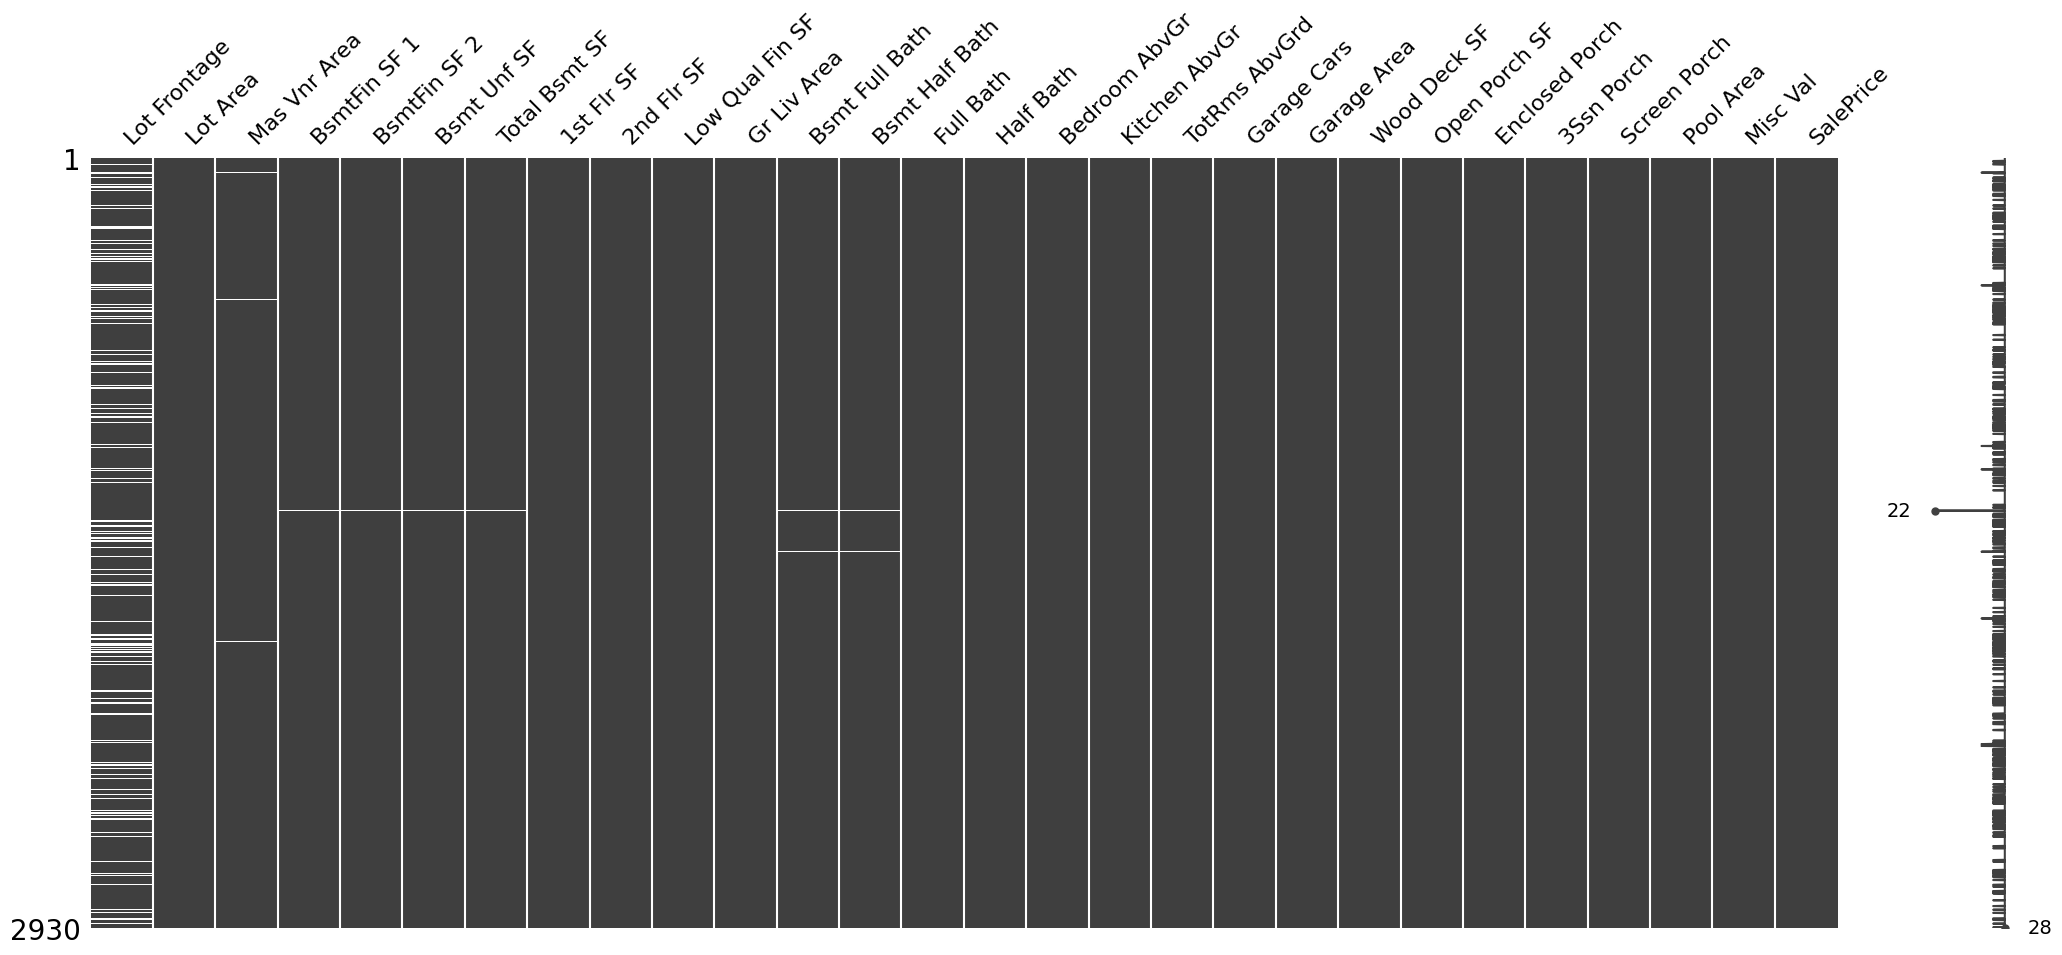

In [454]:
msno.matrix(numeric_df)

In [455]:
numeric_df.corrwith(numeric_df['SalePrice']).sort_values(ascending=False)[1:15]

Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Full Bath         0.545604
Mas Vnr Area      0.508285
TotRms AbvGrd     0.495474
BsmtFin SF 1      0.432914
Lot Frontage      0.357318
Wood Deck SF      0.327143
Open Porch SF     0.312951
Half Bath         0.285056
Bsmt Full Bath    0.276050
dtype: float64

In [456]:
numeric_df["f_surface_habitable"] = numeric_df["Gr Liv Area"]
numeric_df["f_nb_places"] = numeric_df["Garage Cars"]
numeric_df["f_surface_sous_sol"] = numeric_df["Total Bsmt SF"]
numeric_df["f_surface_1er_etage"] = numeric_df["1st Flr SF"]
numeric_df["f_nb_salle_bain"] = numeric_df["Full Bath"]

In [457]:
numeric_df.drop(columns=["Gr Liv Area", "Garage Cars", "Total Bsmt SF", "1st Flr SF", "Full Bath"], inplace=True, axis=1)

#### Variables catégorielles

<Axes: >

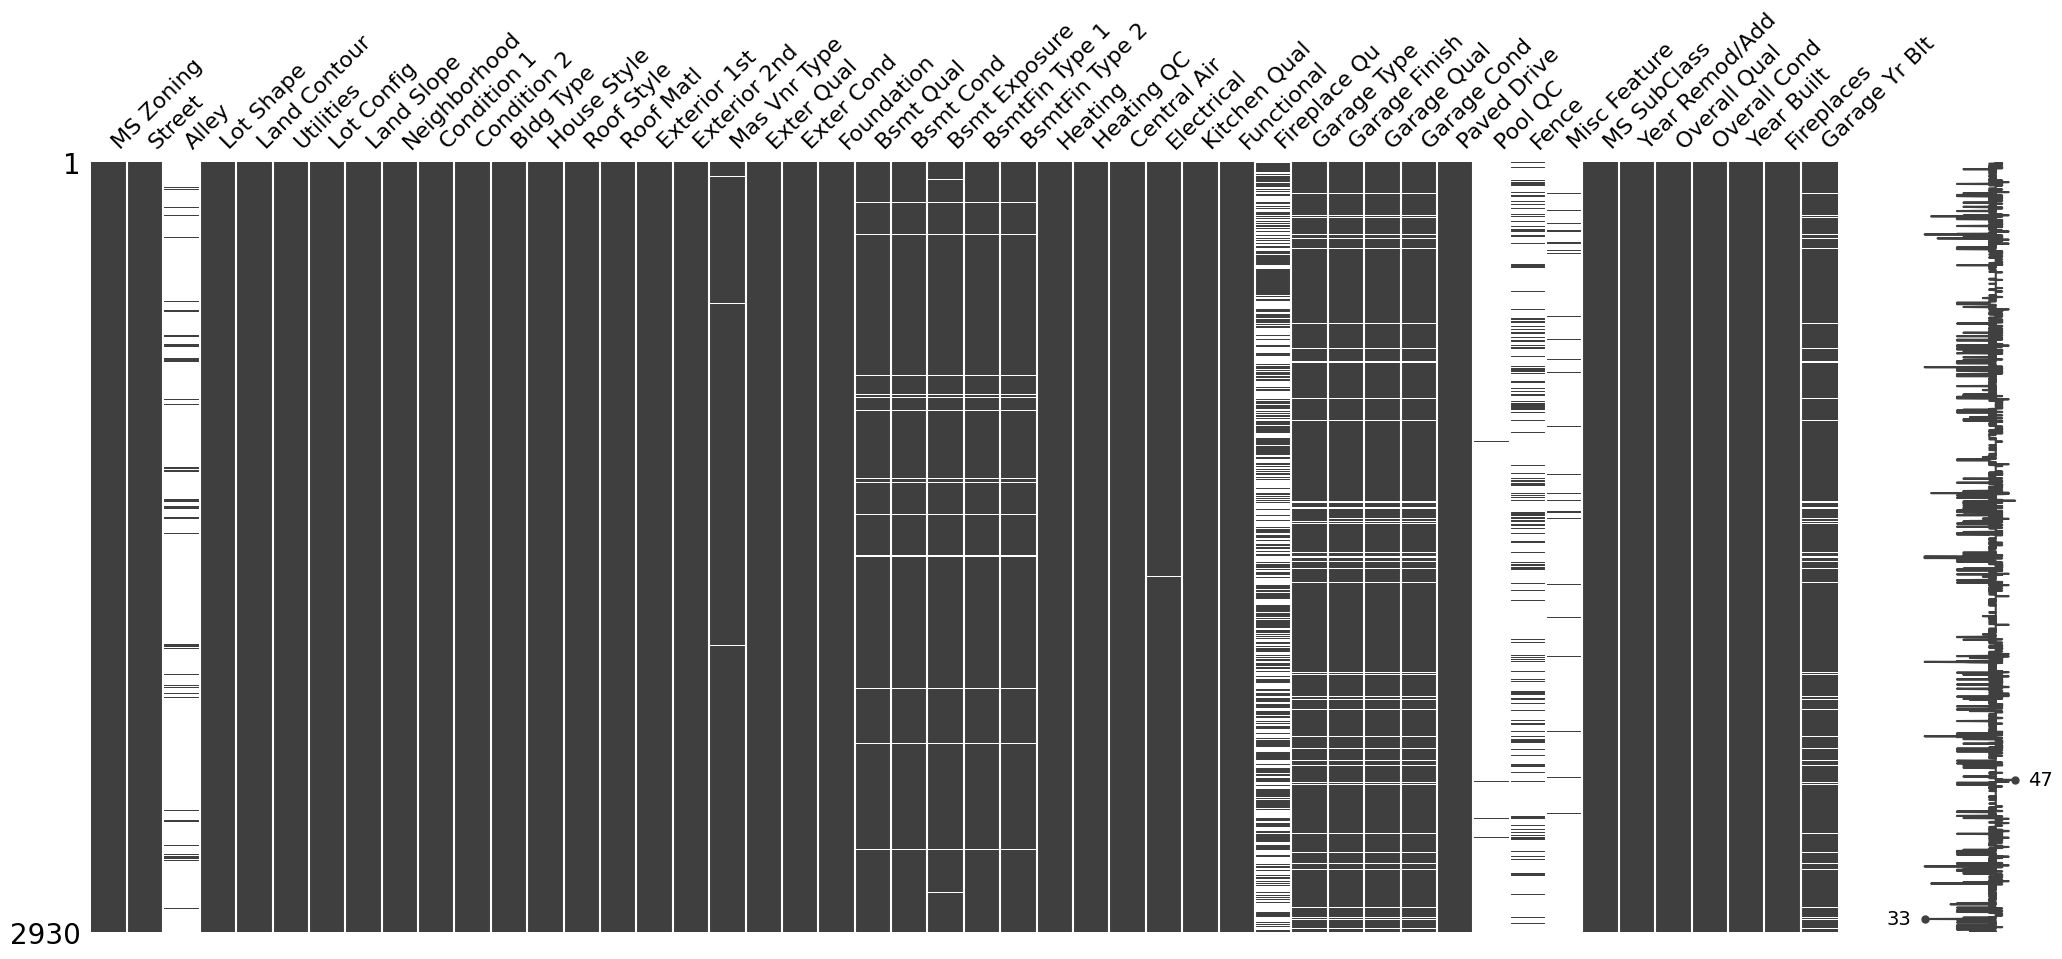

In [458]:
msno.matrix(categorical_df)

- On isole les variables qui ont plus de 90% de manquants
- On les supprime car on part du principe que le modèle n'aura pas assez d'observations pour s'entrainer efficacement

In [459]:
categorical_df= categorical_df.drop(columns=filter_columns_with_missing(categorical_df, 90).columns, index=1)

<Axes: >

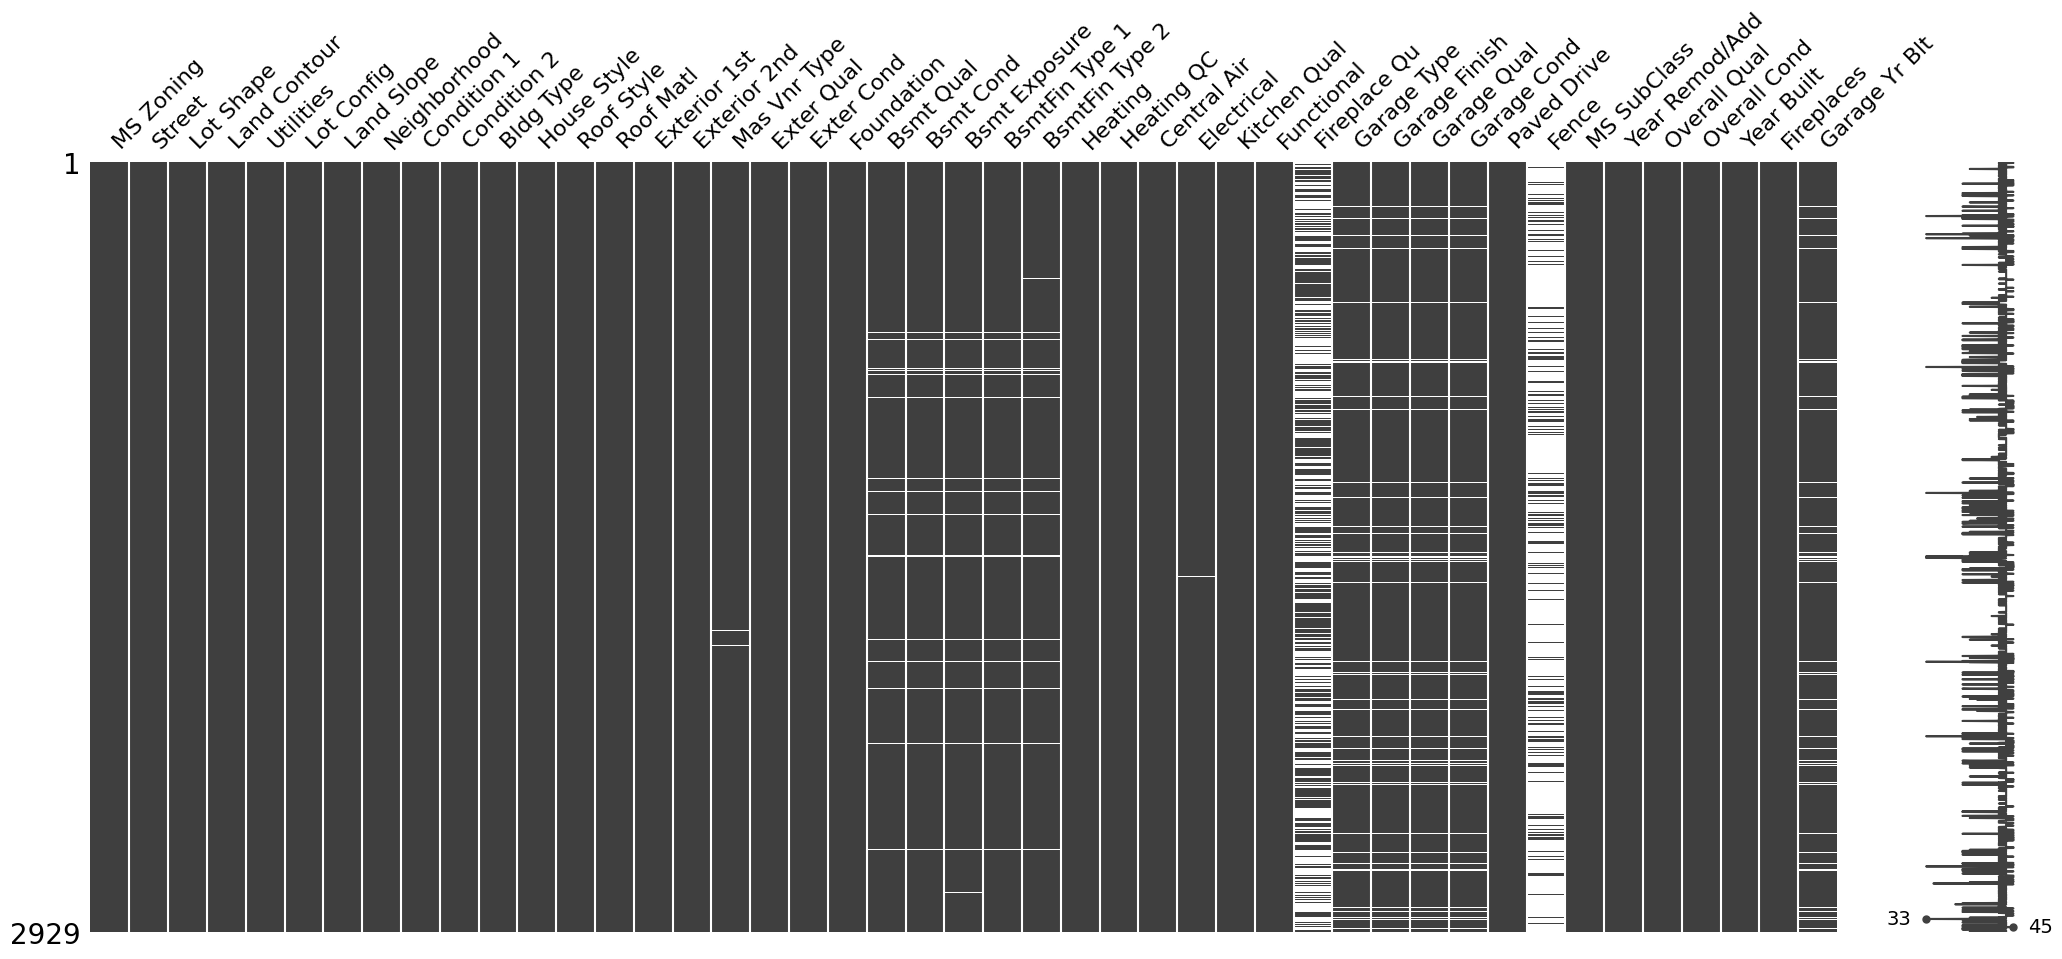

In [460]:
msno.matrix(categorical_df)

##### Ajout de variables explicatives (Concat)

- cheminée : Si Fireplace est NaN alors on considère qu'il n'y a pas de cheminée (O/N)

In [461]:
categorical_df["f_cheminee"] = categorical_df["Fireplace Qu"].apply(lambda x: 1 if str(x) != "nan" else 0)

In [462]:
categorical_df.drop(columns=['Fireplace Qu', 'Fireplaces'], inplace=True, axis=1)

- cave : Si "BsmtQual" est NaN alors on considère qu'il n'y a pas de sous sol (O/N)

In [463]:
categorical_df["f_cave"] = categorical_df["Bsmt Qual"].apply(lambda x: 1 if str(x) != "nan" else 0)

On peut supprimer les variables en rapport avec "Cave"

In [464]:
categorical_df.drop(columns=['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2'], inplace=True, axis=1)

- garage : Si "Garage Type" est a NaN alors on considère qu'il n'y a pas de garage (O/N)

In [465]:
categorical_df["f_garage"] = categorical_df["Garage Type"].apply(lambda x: 1 if str(x) != "nan" else 0)

In [466]:
categorical_df.drop(columns=['Garage Type','Garage Yr Blt', 'Garage Finish', 'Garage Qual', 'Garage Cond'], inplace=True, axis=1)

- condition : Condition 1 , on supprime condition 2

In [467]:
categorical_df['f_condition'] = categorical_df["Condition 1"]
categorical_df.drop(columns=["Condition 2", "Condition 1"], inplace=True, axis=1)

- renov : O/N si le bien a été renové depuis sa construction

In [468]:
categorical_df["f_renov"] = categorical_df.apply(lambda x: 0 if x['Year Built'] == x['Year Remod/Add'] else 1, axis=1)

In [469]:
categorical_df.drop(columns=['Year Remod/Add'], inplace=True, axis=1)

- Barrières O/N

In [470]:
categorical_df["f_cloture"] = categorical_df["Fence"].apply(lambda x: 1 if str(x) != "nan" else 0)

In [471]:
categorical_df["f_annee_construction"] = categorical_df["Year Built"]

In [472]:
categorical_df.drop(columns=['Year Built'], inplace=True, axis=1)

In [473]:
categorical_df.drop(columns=['Fence'], inplace=True, axis=1)

- Chauffage

In [474]:
categorical_df['f_chauffage'] = categorical_df["Heating"]
categorical_df.drop(columns=["Heating", "Heating QC"], inplace=True, axis=1)

In [475]:
categorical_df['f_exter'] = categorical_df["Exter Cond"]
categorical_df.drop(columns=['Exter Qual', 'Exter Cond'], inplace=True, axis=1)

In [476]:
categorical_df['f_cond'] = categorical_df["Overall Cond"]
categorical_df['f_qual'] = categorical_df["Overall Qual"]
categorical_df.drop(columns=['Overall Qual', 'Overall Cond'], inplace=True, axis=1)

In [477]:
categorical_df['f_ZoneIndus'] = categorical_df['MS Zoning'].apply(lambda x: 0 if x in ['FV', 'RH', 'RL', 'RP', 'RM'] else 1)
categorical_df.drop(columns=['MS Zoning'], inplace=True, axis=1)

In [478]:
categorical_df['f_Quartier'] = categorical_df['Neighborhood']
categorical_df.drop(columns=['Neighborhood'], inplace=True, axis=1)

In [479]:
categorical_df['f_style'] = categorical_df['Mas Vnr Type'].apply(lambda x: style_house(x))
categorical_df.drop(columns=['Mas Vnr Type'], inplace=True, axis=1)

In [480]:
categorical_df['f_CuisineQual'] = categorical_df['Kitchen Qual']
categorical_df.drop(columns=['Kitchen Qual'], inplace=True, axis=1)

In [481]:
categorical_df['Central Air'].unique()

array(['Y', 'N'], dtype=object)

In [482]:
categorical_df['f_alleePavee'] = categorical_df['Paved Drive'].apply(lambda x: 1 if x == "Y" else 0)
categorical_df.drop(columns=['Paved Drive'], inplace=True, axis=1)

In [483]:
categorical_df['f_AirClim'] = categorical_df['Central Air'].apply(lambda x: 1 if x == "Y" else 0)
categorical_df.drop(columns=['Central Air'], inplace=True, axis=1)

In [484]:
categorical_df.drop(columns=['Bldg Type', 'Roof Matl', 'Functional', 'MS SubClass', 'Exterior 1st', 'Foundation', 'Roof Style', 'Land Slope', 'House Style','Lot Config', 'Utilities', 'Land Contour', 'Exterior 2nd', 'Lot Shape', 'Street', 'Electrical'], inplace=True, axis=1)

In [485]:
categorical_df.columns

Index(['f_cheminee', 'f_cave', 'f_garage', 'f_condition', 'f_renov',
       'f_cloture', 'f_annee_construction', 'f_chauffage', 'f_exter', 'f_cond',
       'f_qual', 'f_ZoneIndus', 'f_Quartier', 'f_style', 'f_CuisineQual',
       'f_alleePavee', 'f_AirClim'],
      dtype='object')

<Axes: >

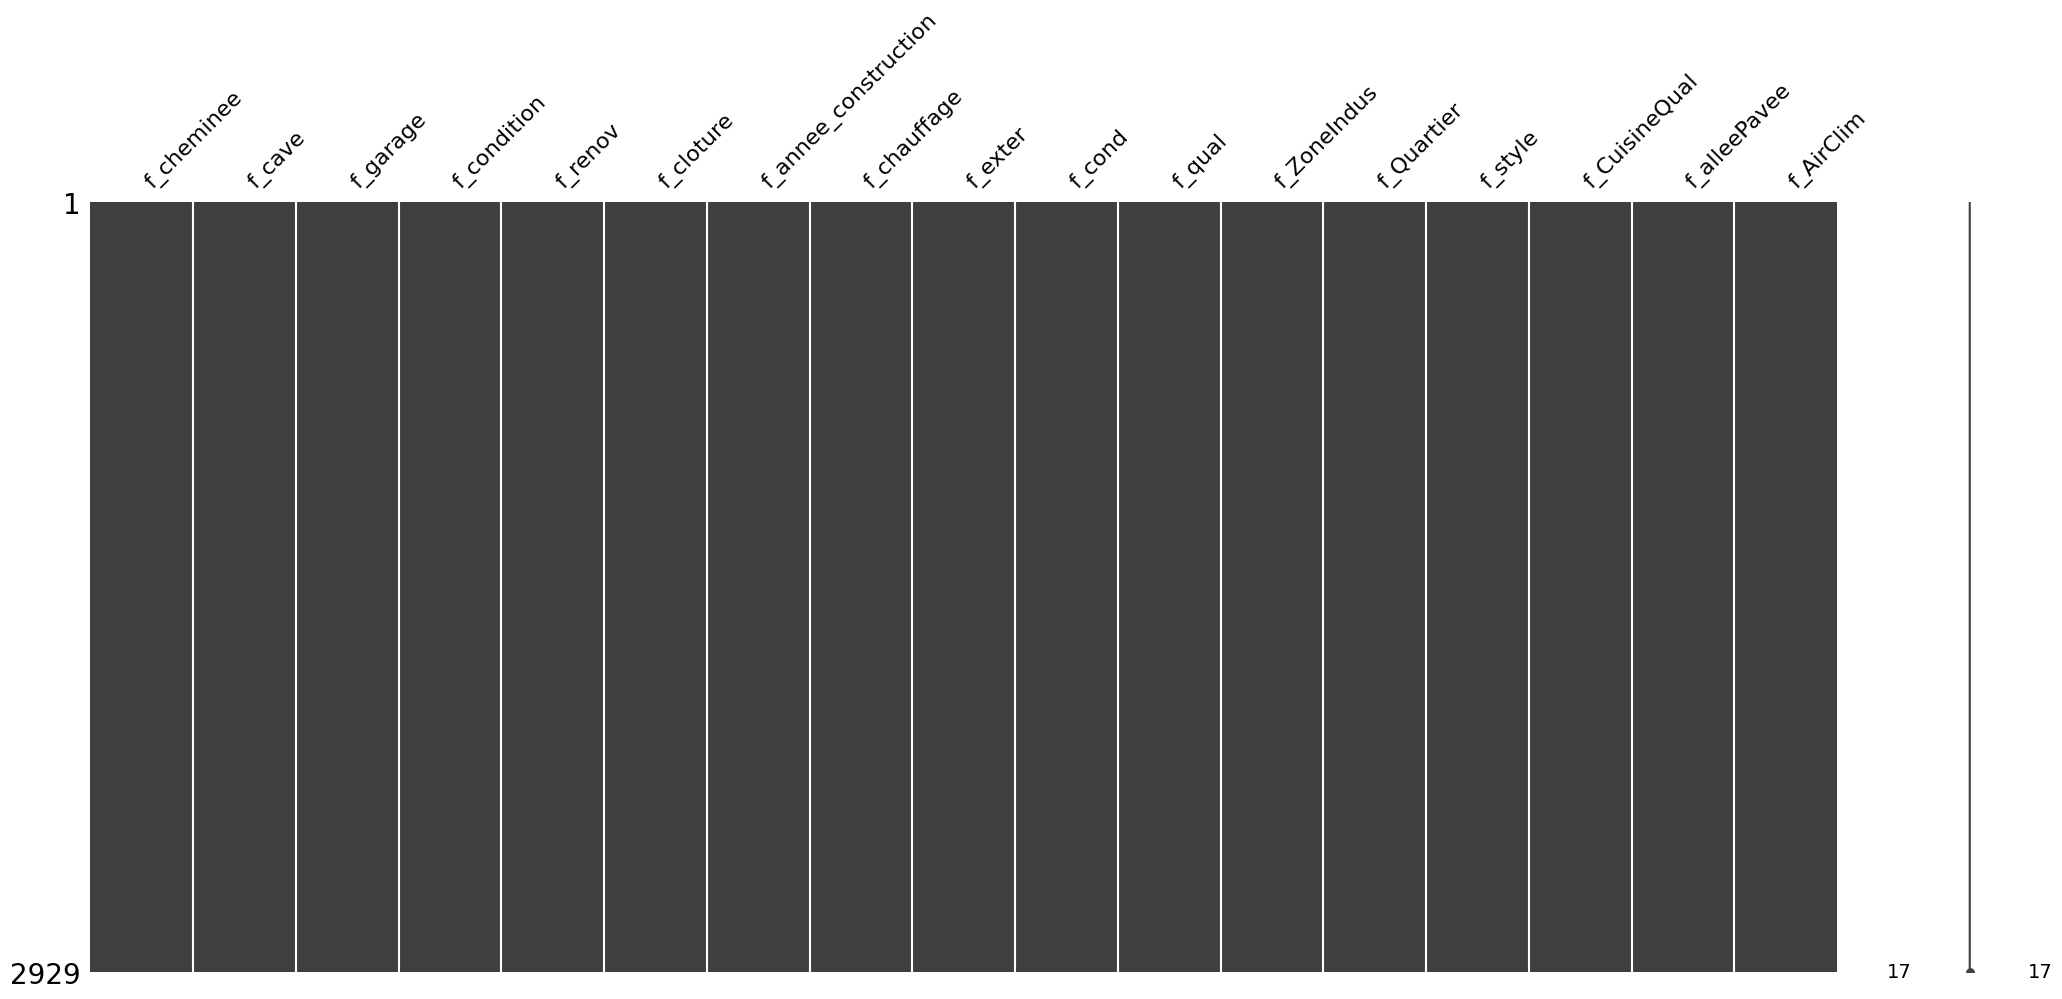

In [486]:
msno.matrix(categorical_df)

In [487]:
pd.get_dummies(categorical_df).corrwith(numeric_df["SalePrice"]).sort_values(ascending=False)[:5]

f_qual                  0.799215
f_annee_construction    0.558412
f_CuisineQual_Ex        0.537562
f_cheminee              0.481273
f_Quartier_NridgHt      0.433291
dtype: float64

## Suite

In [488]:
cat_var = categorical_df.filter(regex=r'^f_')
cat_var = cat_var[['f_qual', 'f_annee_construction', 'f_CuisineQual', 'f_cheminee', 'f_Quartier']]

num_var = numeric_df.filter(regex=r'^f_')
num_var['f_prix'] = numeric_df['SalePrice']

C:\Users\Thomas\AppData\Local\Temp\ipykernel_3960\1049216834.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_var['f_prix'] = numeric_df['SalePrice']


In [489]:
num_var

,f_surface_habitable,f_nb_places,f_surface_sous_sol,f_surface_1er_etage,f_nb_salle_bain,f_prix
0,1656,2.0,1080.0,1656,1,215000
1,896,1.0,882.0,896,1,105000
2,1329,1.0,1329.0,1329,1,172000
3,2110,2.0,2110.0,2110,2,244000
4,1629,2.0,928.0,928,2,189900
...,...,...,...,...,...,...
2925,1003,2.0,1003.0,1003,1,142500
2926,902,2.0,864.0,902,1,131000
2927,970,0.0,912.0,970,1,132000
2928,1389,2.0,1389.0,1389,1,170000


In [490]:
cat_var

,f_qual,f_annee_construction,f_CuisineQual,f_cheminee,f_Quartier
0,6,1960,TA,1,NAmes
2,6,1958,Gd,0,NAmes
3,7,1968,Ex,1,NAmes
4,5,1997,TA,1,Gilbert
5,6,1998,Gd,1,Gilbert
...,...,...,...,...,...
2925,6,1984,TA,0,Mitchel
2926,5,1983,TA,0,Mitchel
2927,5,1992,TA,0,Mitchel
2928,5,1974,TA,1,Mitchel


In [491]:
df_final = cat_var.join(num_var)

In [492]:
df_final.corr()

C:\Users\Thomas\AppData\Local\Temp\ipykernel_3960\2875322423.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_final.corr()


,f_qual,f_annee_construction,f_cheminee,f_surface_habitable,f_nb_places,f_surface_sous_sol,f_surface_1er_etage,f_nb_salle_bain,f_prix
f_qual,1.000000,0.597010,0.436908,0.570437,0.599443,0.547262,0.477745,0.522138,0.799215
f_annee_construction,0.597010,1.000000,0.240330,0.241650,0.537429,0.407500,0.310414,0.469380,0.558412
f_cheminee,0.436908,0.240330,1.000000,0.440433,0.363280,0.309367,0.366879,0.274746,0.481273
f_surface_habitable,0.570437,0.241650,0.440433,1.000000,0.488621,0.444638,0.562072,0.630169,0.706674
f_nb_places,0.599443,0.537429,0.363280,0.488621,1.000000,0.437562,0.439336,0.477997,0.647762
f_surface_sous_sol,0.547262,0.407500,0.309367,0.444638,0.437562,1.000000,0.800714,0.324905,0.632269
f_surface_1er_etage,0.477745,0.310414,0.366879,0.562072,0.439336,0.800714,1.000000,0.371444,0.621602
f_nb_salle_bain,0.522138,0.469380,0.274746,0.630169,0.477997,0.324905,0.371444,1.000000,0.545454
f_prix,0.799215,0.558412,0.481273,0.706674,0.647762,0.632269,0.621602,0.545454,1.000000


In [493]:
df_final = df_final.dropna()

<Axes: >

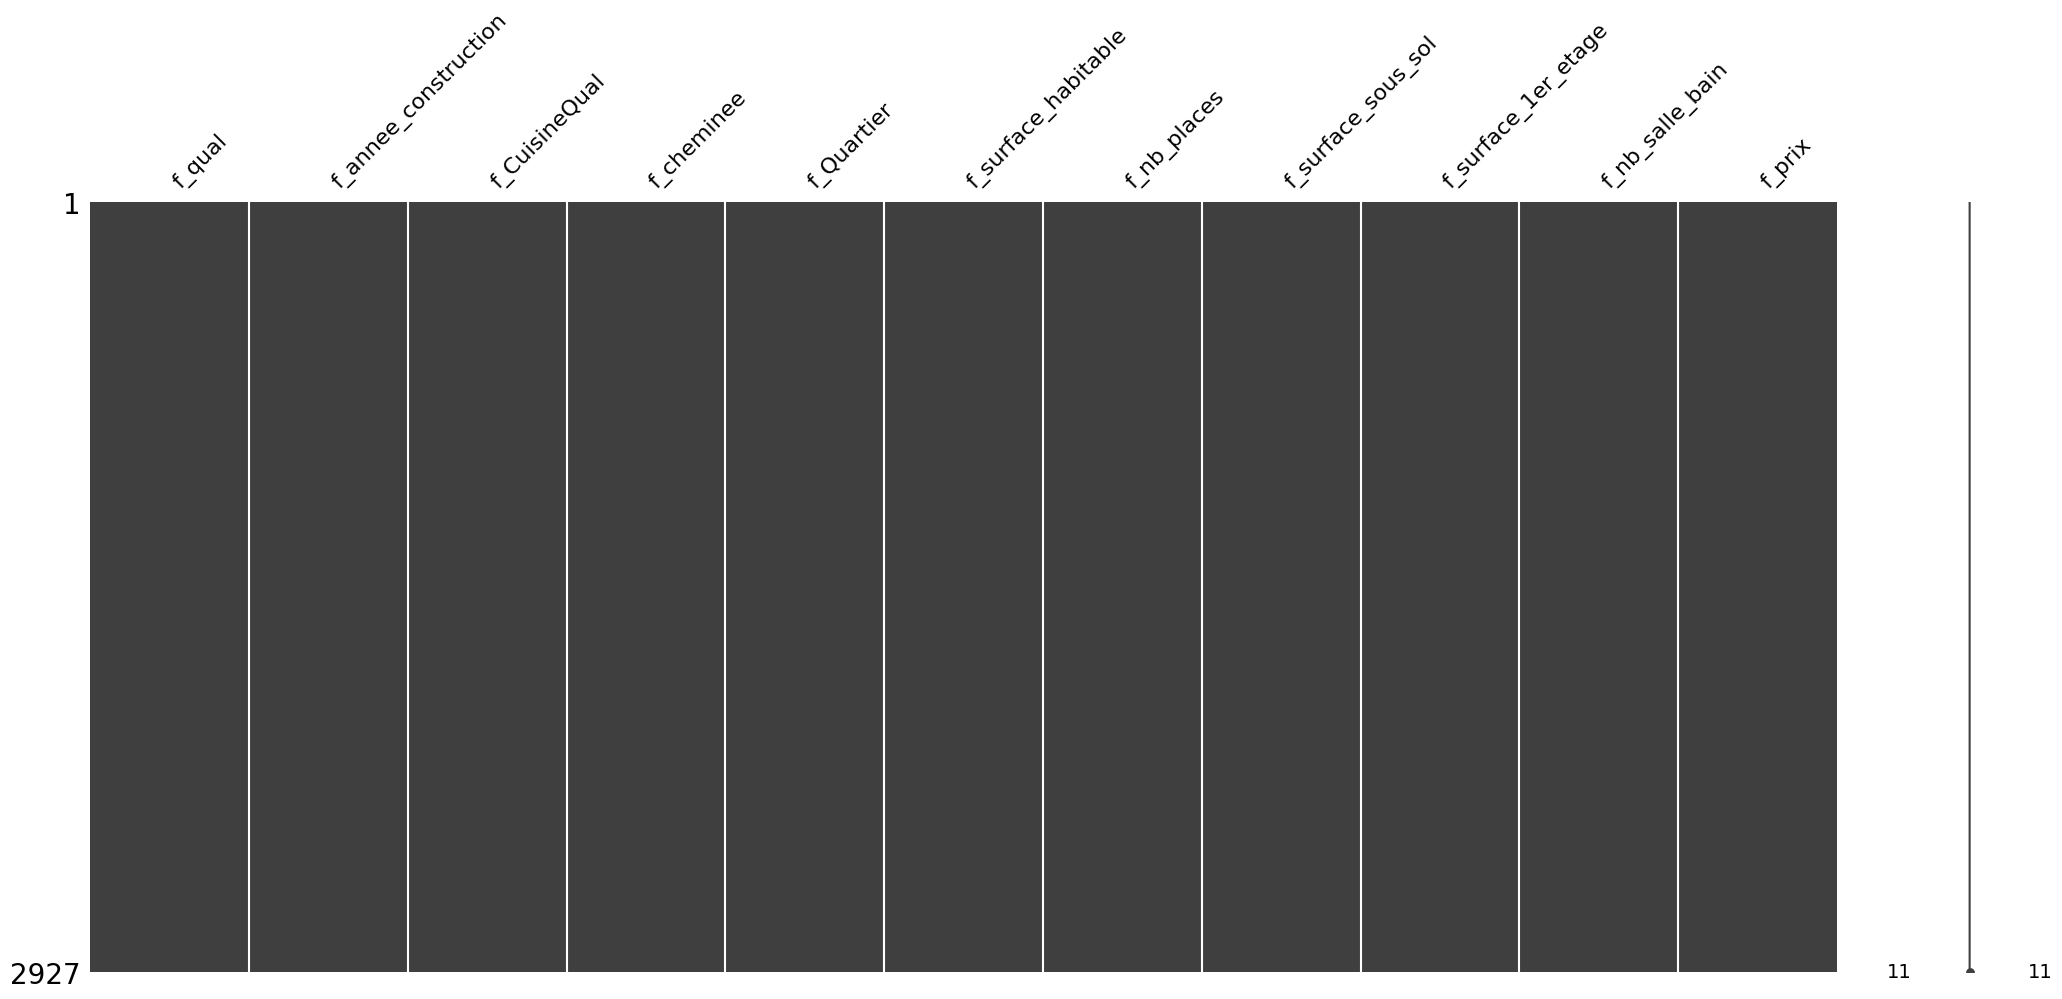

In [494]:
msno.matrix(df_final)

In [495]:
# Liste de valeurs uniques
values_to_remove = [1893, 1879, 1906, 1911, 1896, 1875, 1904, 1902, 1882, 1898, 1907, 1872, 1913]

# Supprimer les lignes correspondantes
df_final = df_final[~df_final['f_annee_construction'].isin(values_to_remove)]

quartier_remove = ['Landmrk', 'GrnHill']
df_final = df_final[~df_final['f_Quartier'].isin(quartier_remove)]

In [496]:
df_final['f_annee_construction'].unique()

array([1960, 1958, 1968, 1997, 1998, 2001, 1992, 1995, 1999, 1993, 1990,
       1985, 2003, 1988, 2010, 1951, 1978, 1977, 1974, 2000, 1970, 1971,
       1975, 2009, 2007, 2005, 2004, 2002, 2006, 1996, 1994, 2008, 1980,
       1979, 1984, 1920, 1961, 1965, 1967, 1963, 1962, 1976, 1972, 1966,
       1959, 1964, 1950, 1952, 1949, 1940, 1954, 1955, 1957, 1956, 1953,
       1948, 1900, 1910, 1927, 1915, 1945, 1929, 1938, 1923, 1928, 1890,
       1885, 1922, 1925, 1939, 1942, 1936, 1930, 1921, 1912, 1917, 1969,
       1947, 1946, 1987, 1941, 1924, 1914, 1931, 1919, 1989, 1973, 1991,
       1981, 1986, 1916, 1926, 1935, 1892, 1880, 1937, 1934, 1982, 1983,
       1932, 1918, 1905, 1908, 1895, 1901], dtype=int64)

In [498]:
df_final['f_annee_construction'] = pd.cut(df_final['f_annee_construction'], bins=[1800, 1900, 1950, 1980, 2000, 2023], labels=['avant 1900', '1900-1950', '1950-1980', '1980-2000', 'après 2000'])

In [500]:
df_final.to_csv("data.csv", index=False)